In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May  4 12:02:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

In [ ]:
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

In [ ]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 1680
    })
})

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(timit["train"].remove_columns(["audio", "file"]), num_examples=10)

In [ ]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch
    
def Caps(batch):
    batch["text"] = batch["text"].upper()
    return batch

In [ ]:
timit = timit.map(remove_special_characters)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
timit = timit.map(Caps)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
show_random_elements(timit["train"].remove_columns(["audio", "file"]))

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'V': 0,
 ' ': 1,
 'X': 2,
 'E': 3,
 'N': 4,
 'I': 5,
 'G': 6,
 'D': 7,
 'U': 8,
 'R': 9,
 'S': 10,
 'Q': 11,
 'T': 12,
 'Y': 13,
 'C': 14,
 'W': 15,
 'P': 16,
 'H': 17,
 'B': 18,
 'K': 19,
 'Z': 20,
 'M': 21,
 'J': 22,
 'A': 23,
 'L': 24,
 "'": 25,
 'F': 26,
 'O': 27}

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

# tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-base-960h")

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

In [ ]:
# from transformers import Wav2Vec2Tokenizer
# tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")

In [ ]:
repo_name = "SEwav2vec2-base-timit-finetune"

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)


In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)


In [ ]:
timit["train"][0]["file"]

'/root/.cache/huggingface/datasets/downloads/extracted/404950a46da14eac65eb4e2a8317b1372fb3971d980d91d5d5b221275b1fd7e0/data/TRAIN/DR4/MMDM0/SI681.WAV'

In [ ]:
timit["train"][0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/404950a46da14eac65eb4e2a8317b1372fb3971d980d91d5d5b221275b1fd7e0/data/TRAIN/DR4/MMDM0/SI681.WAV',
 'array': array([-2.1362305e-04,  6.1035156e-05,  3.0517578e-05, ...,
        -3.0517578e-05, -9.1552734e-05, -6.1035156e-05], dtype=float32),
 'sampling_rate': 16000}

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(timit["train"]))

print(timit["train"][rand_int]["text"])
ipd.Audio(data=np.asarray(timit["train"][rand_int]["audio"]["array"]), autoplay=True, rate=16000)

DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT 


In [ ]:
import numpy as np

In [ ]:
rand_int = random.randint(0, len(timit["train"]))

print("Target text:", timit["train"][rand_int]["text"])
print("Input array shape:", np.asarray(timit["train"][rand_int]["audio"]["array"]).shape)
print("Sampling rate:", timit["train"][rand_int]["audio"]["sampling_rate"])

Target text: IT WAS AS BLISSFUL AND FULFILLING A NIGHT AS ANY BRIDE EVER EXPERIENCED 
Input array shape: (73524,)
Sampling rate: 16000


In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

In [ ]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
wer_metric = load_metric("wer")

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")  

In [ ]:
from torch import nn

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1)
        # import code
        # code.interact(local=locals())
        return x * y.expand_as(x)

In [ ]:
class CustomWav2vecCnnLayer(nn.Module):
    def __init__(self, conv_layer):
        super().__init__()
        self.CNN_layer = conv_layer
        self.custom_layer = SEBlock(512)
    
    def forward(self, x):
        bert_out = self.CNN_layer(x)
        K = self.custom_layer(bert_out)
        # print(type(K))
        # import code
        # code.interact(local=locals())
        # tens = torch.tensor(K[0])
        # import code
        # code.interact(local=locals())
        # tens = tens.unsqueeze(0)
        return K

In [ ]:
# model.wav2vec2.feature_extractor.conv_layers[0] = CustomWav2vecCnnLayer(model.wav2vec2.feature_extractor.conv_layers[0])
# model.wav2vec2.feature_extractor.conv_layers[1] = CustomWav2vecCnnLayer(model.wav2vec2.feature_extractor.conv_layers[1])
model.wav2vec2.feature_extractor.conv_layers[2] = CustomWav2vecCnnLayer(model.wav2vec2.feature_extractor.conv_layers[2])
# model.wav2vec2.feature_extractor.conv_layers[3] = CustomWav2vecCnnLayer(model.wav2vec2.feature_extractor.conv_layers[3])
# model.wav2vec2.feature_extractor.conv_layers[4] = CustomWav2vecCnnLayer(model.wav2vec2.feature_extractor.conv_layers[4])
# model.wav2vec2.feature_extractor.conv_layers[5] = CustomWav2vecCnnLayer(model.wav2vec2.feature_extractor.conv_layers[5])

In [ ]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): CustomWav2vecCnnLayer(
          (CNN_layer): Wav2Vec2NoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
          (custom_layer): SEBlock(
            (global_pool): AdaptiveAvgPool1d(output_size=1)
            (fc1): Linear(in_features=512, out_features=32, bias=True)
            (fc2): Linear(in_features=32, out_features=512, bias=True)
   

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=24,
  evaluation_strategy="epoch",
  num_train_epochs=30,
  fp16=True,
  gradient_checkpointing=True,
  logging_steps=1,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor
)

Using amp half precision backend


In [ ]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): CustomWav2vecCnnLayer(
          (CNN_layer): Wav2Vec2NoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
          (custom_layer): SEBlock(
            (global_pool): AdaptiveAvgPool1d(output_size=1)
            (fc1): Linear(in_features=512, out_features=32, bias=True)
            (fc2): Linear(in_features=32, out_features=512, bias=True)
   

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = True

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3978
  Num Epochs = 30
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 4980


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8
Saving model checkpoint to SEwav2vec2-base-timit-finetu

The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8
Saving model checkpoint to SEwav2vec2-base-timit-finetune/checkpoint-3500
Configuration saved in SEwav2vec2-base-timit-finetune/checkpoint-3500/config.json
Model weights saved in SEwav2vec2-base-timit-finetune/checkpoint-3500/pytorch_model.bin
Feature extractor saved in SEwav2vec2-base-timit-finetune/checkpoint-3500/preprocessor_config.json
Deleting older checkpoint [SEwav2vec2-base-timit-finetune/checkpoint-2500] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this me

TrainOutput(global_step=4980, training_loss=149.343889965494, metrics={'train_runtime': 6947.9359, 'train_samples_per_second': 17.176, 'train_steps_per_second': 0.717, 'total_flos': 3.092086917292159e+18, 'train_loss': 149.343889965494, 'epoch': 30.0})

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): CustomWav2vecCnnLayer(
          (CNN_layer): Wav2Vec2NoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
          (custom_layer): SEBlock(
            (global_pool): AdaptiveAvgPool1d(output_size=1)
            (fc1): Linear(in_features=512, out_features=32, bias=True)
            (fc2): Linear(in_features=32, out_features=512, bias=True)
   

In [ ]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
  return batch

In [ ]:
results = timit["test"].map(map_to_result, remove_columns=timit["test"].column_names)

0ex [00:00, ?ex/s]

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.090


In [ ]:
#predictions
show_random_elements(results)

In [ ]:
import pandas as pd

# assume `trainer` is your Trainer object
log_history = trainer.state.log_history

# convert log history to DataFrame
df = pd.DataFrame(log_history)

# save DataFrame to CSV file
df.to_csv("trainer_log_30_epoch_2.csv", index=False)

In [ ]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
from transformers import Wav2Vec2Processor

In [ ]:
model_p = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

loading configuration file https://huggingface.co/facebook/wav2vec2-base-960h/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cbb3014bb9f03ead9b94f4a791ff8e777465307670e85079d35e28cbc5d88727.0e2d739358c9b58747bd19db5f9f4320dacabbeb1e6282f5cc1069c5c55a82d2
Model config Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base-960h",
  "activation_dropout": 0.1,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": fals

In [ ]:
model.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): CustomWav2vecCnnLayer(
          (CNN_layer): Wav2Vec2NoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
          (custom_layer): SEBlock(
            (global_pool): AdaptiveAvgPool1d(output_size=1)
            (fc1): Linear(in_features=512, out_features=32, bias=True)
            (fc2): Linear(in_features=32, out_features=512, bias=True)
   

In [ ]:
model_p.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
conv_layers_t = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv1d)]


In [ ]:
conv_layers_p = [layer for layer in model_p.modules() if isinstance(layer, torch.nn.Conv1d)]

In [ ]:
processor_p = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
tokenizer_p = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")

https://huggingface.co/facebook/wav2vec2-base-960h/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp75foprmd


Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

storing https://huggingface.co/facebook/wav2vec2-base-960h/resolve/main/preprocessor_config.json in cache at /root/.cache/huggingface/transformers/07e398f6c4f4eb4f676c75befc5ace223491c79cea1109fb4029751892d380a1.bc3155ca0bae3a39fc37fc6d64829c6a765f46480894658bb21c08db6155358d
creating metadata file for /root/.cache/huggingface/transformers/07e398f6c4f4eb4f676c75befc5ace223491c79cea1109fb4029751892d380a1.bc3155ca0bae3a39fc37fc6d64829c6a765f46480894658bb21c08db6155358d
loading feature extractor configuration file https://huggingface.co/facebook/wav2vec2-base-960h/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/07e398f6c4f4eb4f676c75befc5ace223491c79cea1109fb4029751892d380a1.bc3155ca0bae3a39fc37fc6d64829c6a765f46480894658bb21c08db6155358d
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_atten

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np

audio_file_1, sample_rate = torchaudio.load("sa1.wav")
audio_file_2, sample_rate = torchaudio.load("sa2.wav")
target_sample_rate = 16000

# Resample waveform to the target sample rate
resample_transform = torchaudio.transforms.Resample(sample_rate, target_sample_rate)
audio_file_1 = resample_transform(audio_file_1)

resample_transform = torchaudio.transforms.Resample(sample_rate, target_sample_rate)
audio_file_2 = resample_transform(audio_file_2)

input_values_t = tokenizer_p(audio_file_1, sampling_rate=16000, return_tensors="pt").input_values.cuda()
input_values_p = tokenizer_p(audio_file_1, sampling_rate=16000, return_tensors="pt").input_values
# input_values_t = processor_t(audio_file_1, sampling_rate=16000, return_tensors="pt").input_values
# input_values_p = processor_p(audio_file_1, sampling_rate=16000, return_tensors="pt").input_values
#print(input_values.shape)

original_input_t= input_values_t
original_input_p = input_values_p
conv_layer_outputs_t =[] #store convolutional layer  output for audio 1
conv_layer_outputs_p =[] #store convolutional layer  output for audio 2

print("---Fine Tuned-960h-with-SE ---")
for i, conv_layer in enumerate(conv_layers_t):

    print(f"layer {i}")
    if i !=7: 
      outputs_t = conv_layer(input_values_t) # conv layer output for finetuned model
      conv_layer_outputs_t.append(outputs_t)
    print(outputs_t.shape)
    input_values_t = outputs_t
  
print("---Fine-tunes-without-SE ---")
for i, conv_layer in enumerate(conv_layers_p):

    print(f"layer {i}")
    if i !=7: 
      outputs_p = conv_layer(input_values_p) # conv layer output for pretrained  model
      conv_layer_outputs_p.append(outputs_p)
    print(outputs_p.shape)
    input_values_p = outputs_p


---Fine Tuned-960h-with-SE ---
layer 0
torch.Size([1, 512, 10116])
layer 1
torch.Size([1, 512, 5057])
layer 2
torch.Size([1, 512, 2528])
layer 3
torch.Size([1, 512, 1263])
layer 4
torch.Size([1, 512, 631])
layer 5
torch.Size([1, 512, 315])
layer 6
torch.Size([1, 512, 157])
layer 7
torch.Size([1, 512, 157])
---Fine-tunes-without-SE ---
layer 0
torch.Size([1, 512, 10116])
layer 1
torch.Size([1, 512, 5057])
layer 2
torch.Size([1, 512, 2528])
layer 3
torch.Size([1, 512, 1263])
layer 4
torch.Size([1, 512, 631])
layer 5
torch.Size([1, 512, 315])
layer 6
torch.Size([1, 512, 157])
layer 7
torch.Size([1, 512, 157])


In [ ]:
print(len(conv_layer_outputs_p))
print(len(conv_layer_outputs_t))

7
7


In [ ]:
mean_dist_arr=[]

In [ ]:
#store length of conv layer output
length = len(conv_layer_outputs_t)

In [ ]:
import numpy as np
mfcc_dist_mat = np.ones((6,13))
print(mfcc_dist_mat)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
def store_mfcc_feature(dist_matric,k):
  temp = []
  m,n= dist_matric[0].shape
  mat  = dist_matric[0].detach().numpy()
  for i in range(m):
    mfcc_dist_mat[k][i] = mat[i][i]
  
  # new_row = np.array(temp)
  # print(temp)
  # mfcc_dist_mat = np.vstack([mfcc_dist_mat, temp])


In [ ]:
import librosa

In [ ]:
for i in range(length):
    output_t = conv_layer_outputs_t[i]
    output_p = conv_layer_outputs_p[i]

    
    # mfcc_t = librosa.feature.mfcc(y=output_t[0].detach().numpy(), sr=target_sample_rate, n_mfcc=13)
    # mfcc_p = librosa.feature.mfcc(y=output_p[0].detach().numpy(), sr=target_sample_rate, n_mfcc=13)
    mfcc_t = librosa.feature.mfcc(y=output_t[0].detach().cpu().numpy(), sr=target_sample_rate, n_mfcc=13)
    mfcc_p = librosa.feature.mfcc(y=output_p[0].detach().cpu().numpy(), sr=target_sample_rate, n_mfcc=13)

#     print(output_1.shape)
#     print(output_2.shape)
#     Extract MFCC features
    # mfcc_transform = torchaudio.transforms.MFCC(sample_rate=target_sample_rate, n_mfcc=13)
    # mfcc_t = mfcc_transform(output_t[0])
    # mfcc_p = mfcc_transform(output_p[0])
#     print(mfcc_1.shape)
#     print(mfcc_2.shape)

    mfcc_t = torch.from_numpy(mfcc_t)
    mfcc_p = torch.from_numpy(mfcc_p)
# Pad the smaller tensor with zeros to match the shape of the larger tensor
    if mfcc_t.shape[2] > mfcc_p.shape[2]:
        mfcc_p = torch.nn.functional.pad(mfcc_p, (0, mfcc_t.shape[2] - mfcc_p.shape[2]), "constant", 0)
    else:
        mfcc_t = torch.nn.functional.pad(mfcc_t, (0, mfcc_p.shape[2] - mfcc_t.shape[2]), "constant", 0)

#     print(mfcc_1.shape)
#     print(mfcc_2.shape)
    print(f"MFCC Distance metric for conv layer output-{i}")
    # print(mfcc_t[0])
    # print(mfcc_p[0])

#Calculate pairwise distance between MFCC frames
    distance = torch.cdist(mfcc_t, mfcc_p)
# Calculate mean distance across frames
# print(mfcc_1)
# print(mfcc_2)
    min_distance = torch.min(distance)
    max_distance = torch.max(distance)
# print(min_distance,max_distance)
   
    distance = (distance - min_distance) / (max_distance - min_distance)#moramalized distance
    mean_distance = distance.mean()
    mean_dist_arr.append(mean_distance)
    store_mfcc_feature(distance,i)
#     print(distance.shape)

#     print(distance.shape)
# print(distance[0].detach().numpy())
# print("MFCC distance between the two tensors:", mean_distance.item())
    plt.figure(figsize=(16, 8))
# Create a heatmap of the distance matrix using seaborn
    sns.heatmap(distance[0].detach().numpy(),annot=True, cmap="viridis")

# Set the axis labels and title
    # plt.xlabel("Second waveform")
    # plt.ylabel("First waveform")
    plt.xlabel("Pretrained model")
    plt.ylabel("fineTune model")
    plt.title("MFCC distance matrix")

# Show the plot
    plt.show()

In [ ]:
print(mfcc_dist_mat)

[[0.00158943 0.00092841 0.00038252 0.00038711 0.0001516  0.00027026
  0.00014527 0.00031458 0.00022692 0.00015284 0.00040194 0.00017968
  0.00028949]
 [0.00931715 0.00379644 0.00414281 0.0036205  0.00368184 0.00213942
  0.00165776 0.00226813 0.00258646 0.00137926 0.00240605 0.00147684
  0.0022441 ]
 [0.0175447  0.00941281 0.00565836 0.0053716  0.00641174 0.00530046
  0.0039025  0.0058689  0.00906414 0.00525114 0.0038909  0.00603221
  0.00477231]
 [0.00235819 0.01889417 0.01017662 0.00600004 0.00367442 0.00802105
  0.00272438 0.00304621 0.00220927 0.00550216 0.00212057 0.00215661
  0.00196574]
 [0.00924014 0.00310333 0.00482386 0.00084585 0.00272852 0.00376025
  0.0024592  0.00554952 0.00397184 0.00204488 0.00198606 0.00041533
  0.00146212]
 [0.0037914  0.00022633 0.00690972 0.00159941 0.00111439 0.00118059
  0.00258    0.00380106 0.00317333 0.00110753 0.00356564 0.00373724
  0.00027069]]


In [ ]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

#SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_SPEECH  = 'sx57.wav'

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

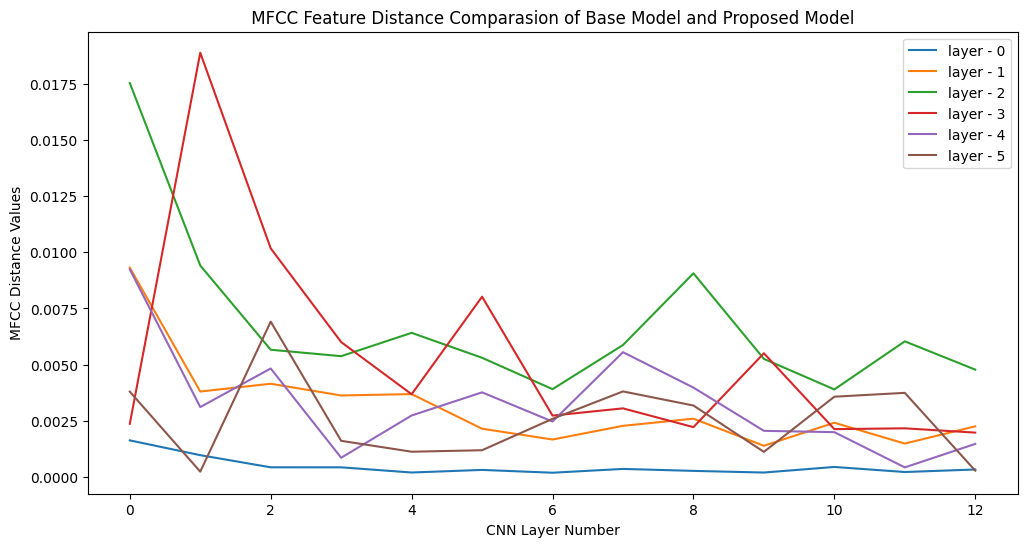

In [ ]:
plt.figure(figsize=(12, 6))

# labels = ['a', 'b', 'c', 'd', 'e','f']
# labels = np.array(labels)
# plt.plot(mfcc_dist_mat.T)
F = []
for i in range(13):
  F.append(i)
for i in range(6):
  plt.plot(F,mfcc_dist_mat[i],label = f"layer - {i}")
plt.ylabel("MFCC Distance Values")
plt.xlabel("MFCC Cofficient Index (i)")
plt.title(" MFCC Feature Distance Comparasion of Base Model and Proposed Model ")
plt.legend()
plt.show()